In [60]:
%pylab inline
rcParams['figure.max_open_warning'] = False
from scipy.stats import scoreatpercentile
from astropy.stats import sigma_clip
from bokpipe.bokproc import ampOrder
import os,sys
gpath = os.path.join(os.environ['BOK90PRIMEOUTDIR'],'bokpipe_v0.1','diagnostics')
sys.path.append('..')
import bokrmgnostic
gaindat = bokrmgnostic.all_gain_vals(gpath)

Populating the interactive namespace from numpy and matplotlib


In [77]:
nim = len(gaindat)
utds = unique(gaindat['utDate'])
nutd = len(utds)
utindex = [where(utds==utd)[0][0] for utd in gaindat['utDate']]
colorval = 256 * array(utindex).astype(float) / nutd
colorz = cm.jet(colorval.astype(int))
uts = array([int(utd) for utd in gaindat['utDate']])
runBreaks = 1 + where(diff(uts)>=3)[0]
nightBreaks = 1 + where(diff(uts)>=1)[0]

In [90]:
def plotgains(norm=False,fromsky=False,ampref=[2,1,1,0],ccdref=2):
    for j in [0,1]:
        if j==0:
            ks1 = array([0,4,8,12]) + array(ampref)
        else:
            ks1 = [ccdref]
#        ks = [[0,4,8,12],[0]][j]
#        dks = [[1,2,3],[4,8,12]][j]
        for ccdi,k1 in enumerate(ks1):
            if j==0:
                ks2 = 4*ccdi + np.arange(4)
            else:
                ks2 = 4*np.arange(4)
                ks2[ccdref//4] = ccdref
            for ampj,k2 in enumerate(ks2):
                if k1==k2:
                    continue
                figure(figsize=(12,4))
                for pnum,filt in enumerate('gi',start=1):
                    subplot(1,2,pnum)
                    ii = where(gaindat['filt']==filt)[0]
                    if fromsky:
                        gratio = gaindat['skys'][ii,k2]/gaindat['skys'][ii,k1]
                    else:
                        gratio = gaindat['gains'][ii,j,k2]/gaindat['gains'][ii,j,k1]
                    if norm:
                        for utd in utds:
                            ii2 = where(gaindat['utDate'][ii]==utd)[0]
                            if len(ii2)==0: continue
                            gratio[ii2] /= gratio[ii2].mean()
                    scatter(gaindat['skys'][ii,j],gratio,
                            marker={'g':'o','i':'s'}[filt],edgecolors='none',
                            c=colorz[ii],alpha=0.7)
                    if norm: axhline(1,c='k')
                    title('filt=%s cor=%d IM%d/IM%d' %(filt,j,ampOrder[k2],ampOrder[k1]))
                    xlim({'g':700,'i':2000}[filt],40000)
                    if norm:
                        ylim(0.975,1.025)
                    else:
                        ylim(0.99*scoreatpercentile(gratio,1),
                             1.01*scoreatpercentile(gratio,99))
                    xscale('log')

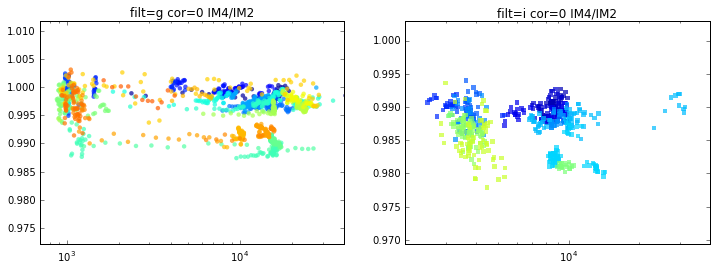

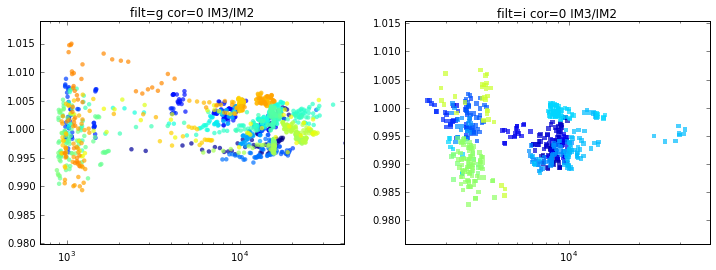

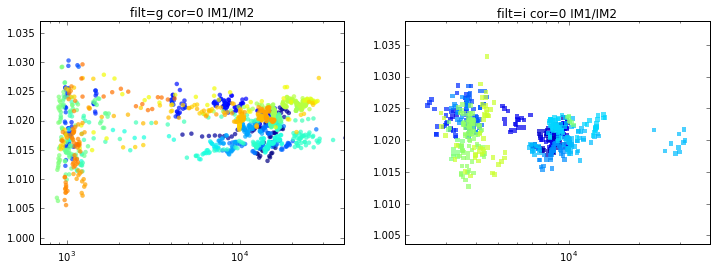

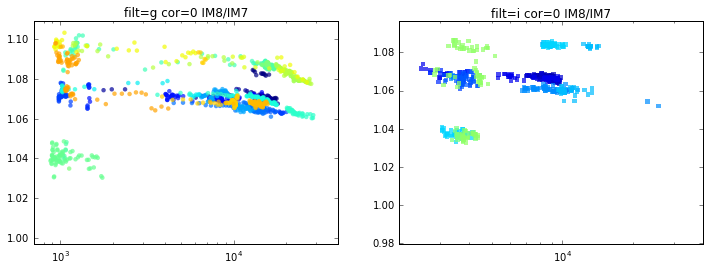

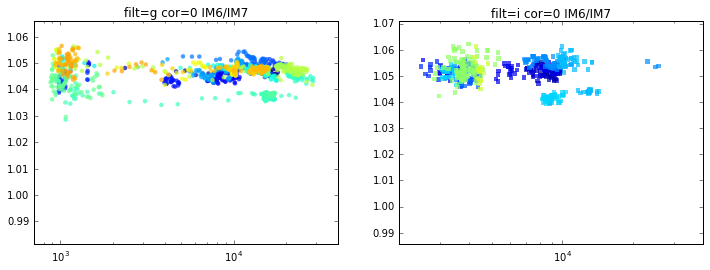

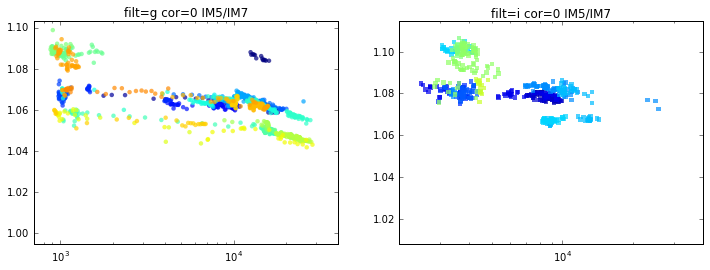

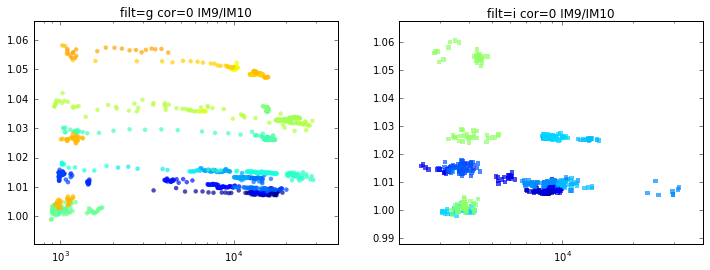

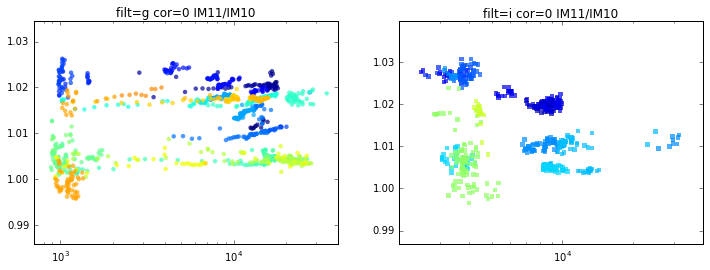

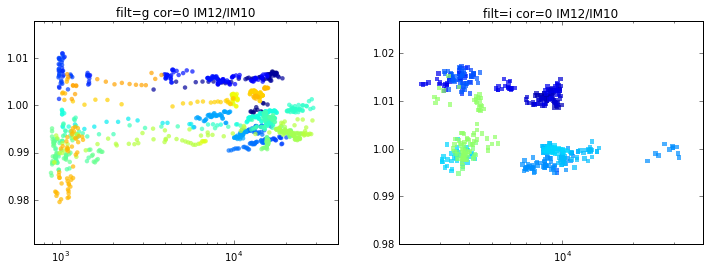

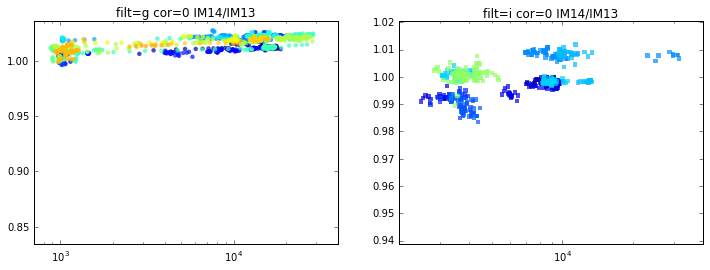

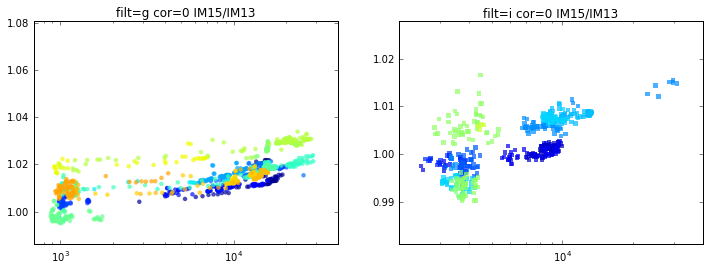

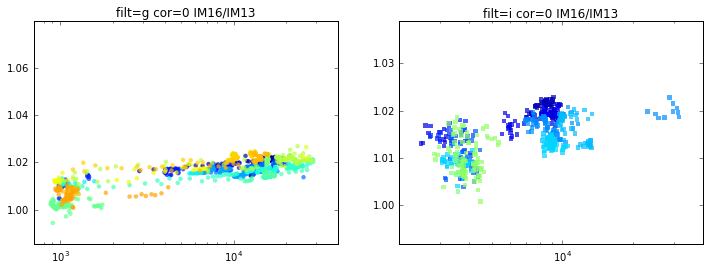

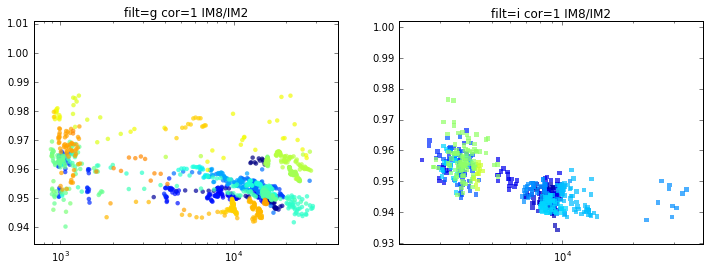

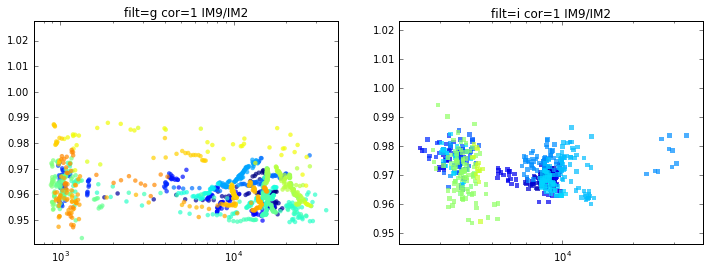

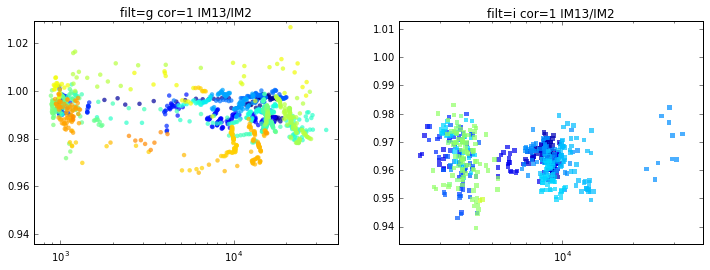

In [91]:
plotgains()

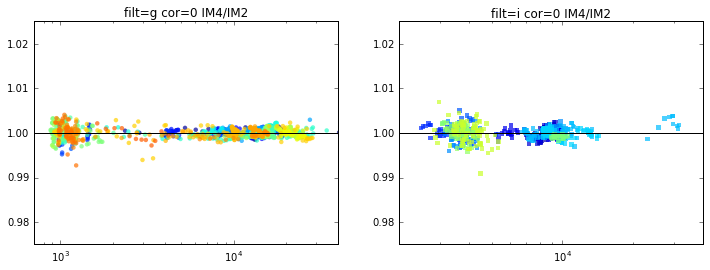

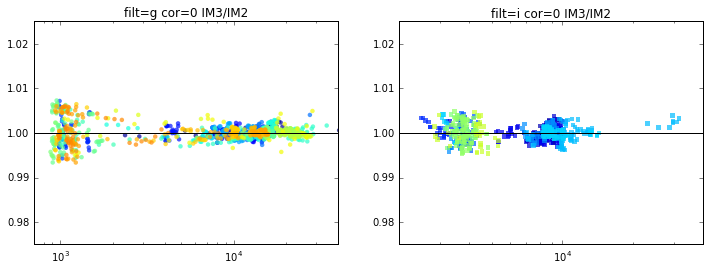

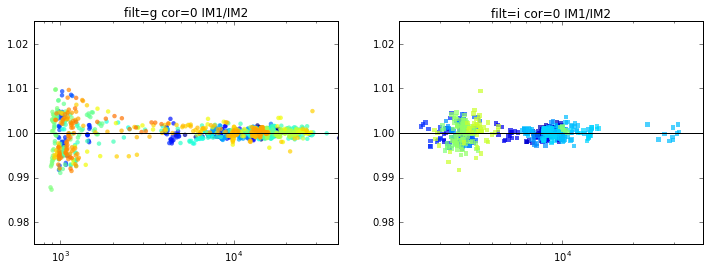

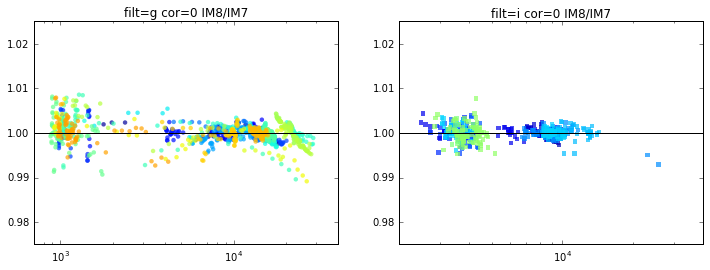

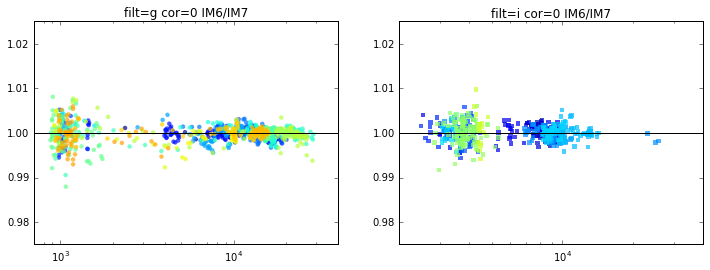

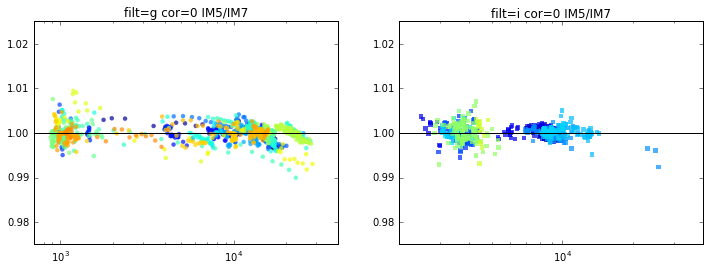

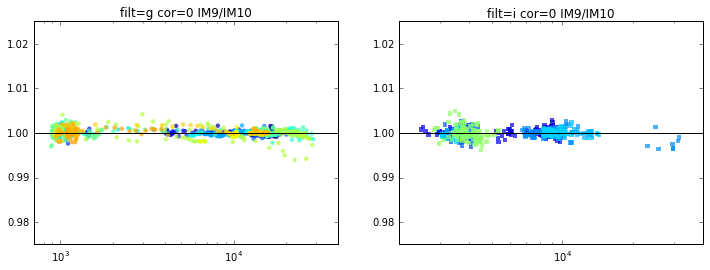

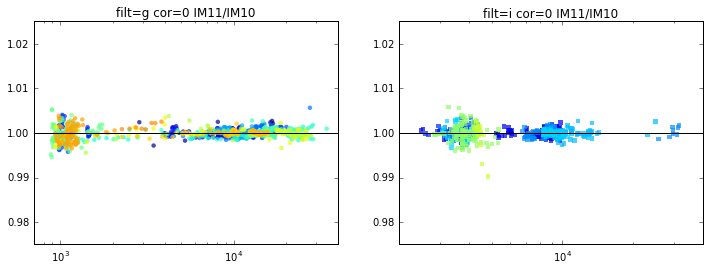

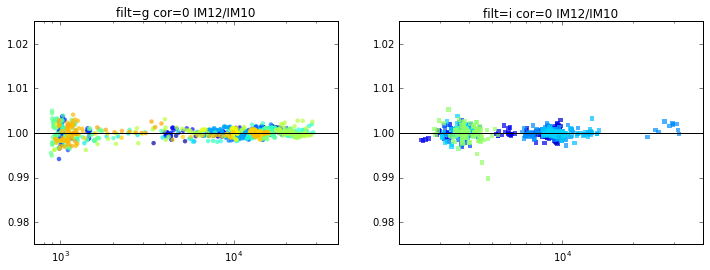

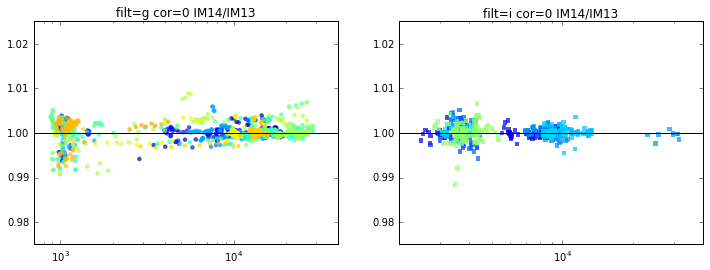

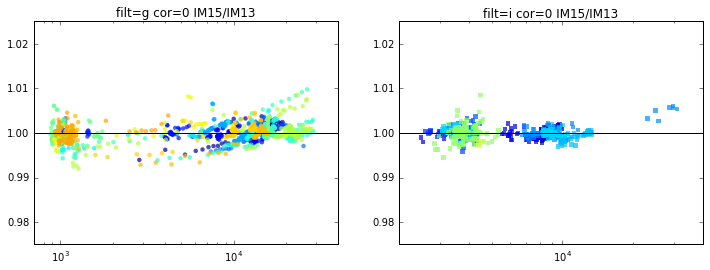

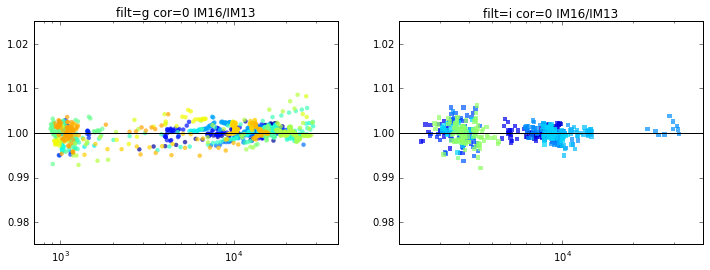

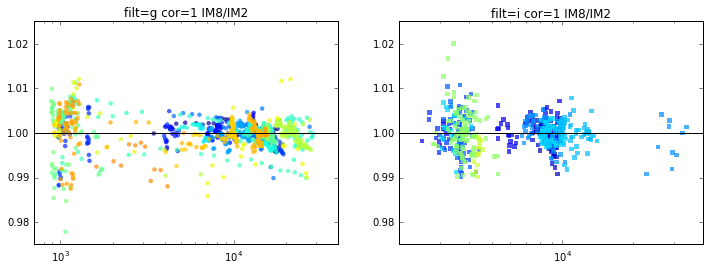

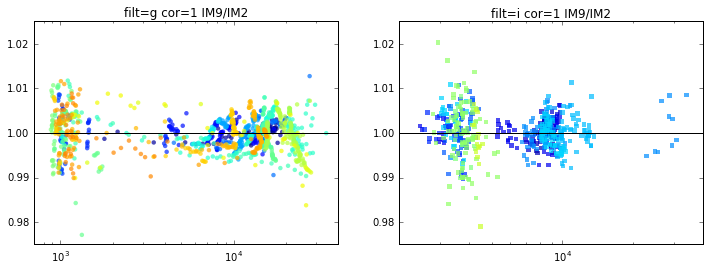

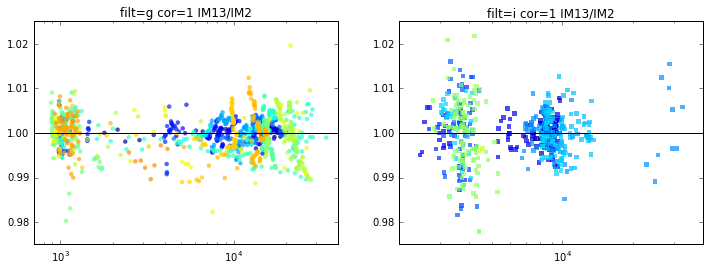

In [92]:
plotgains(norm=True)

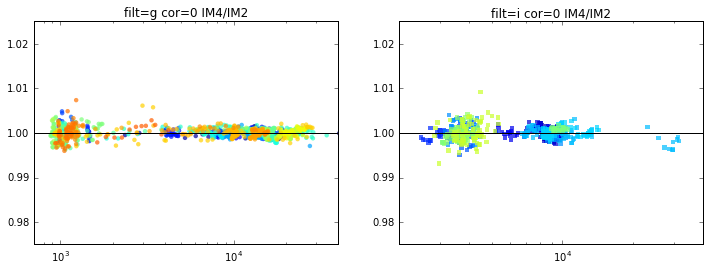

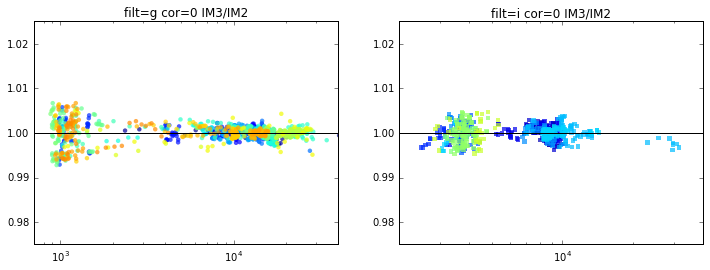

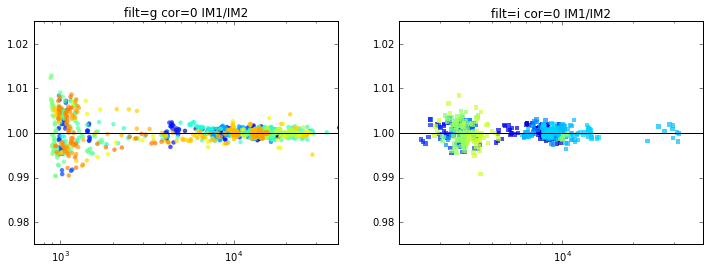

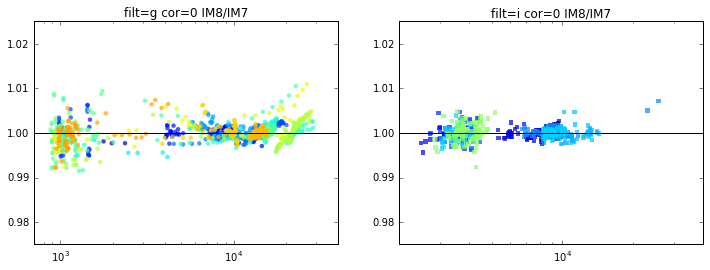

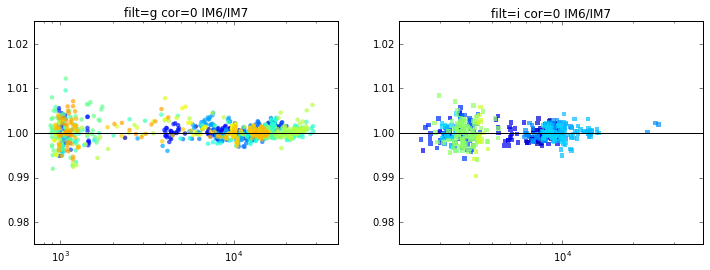

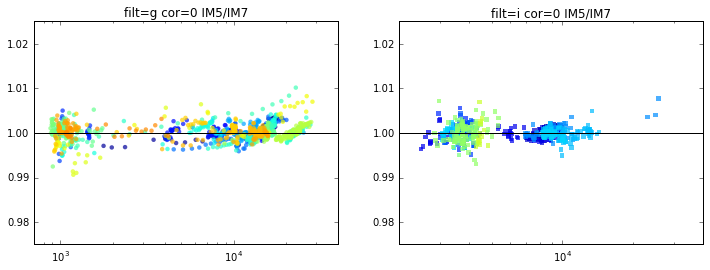

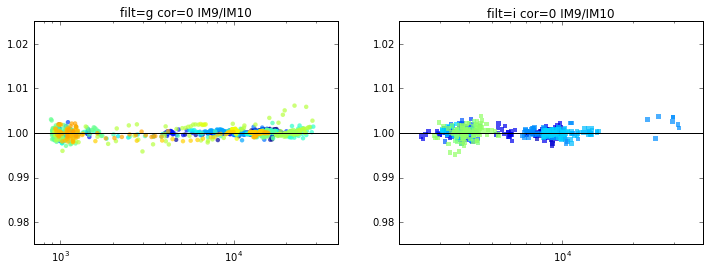

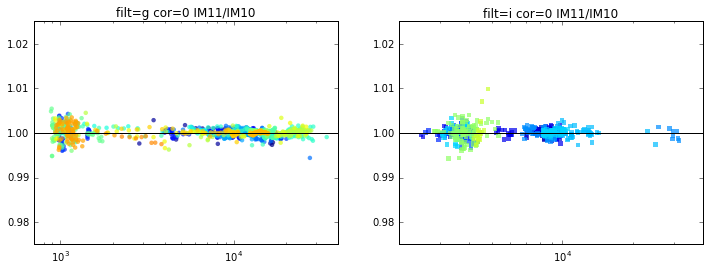

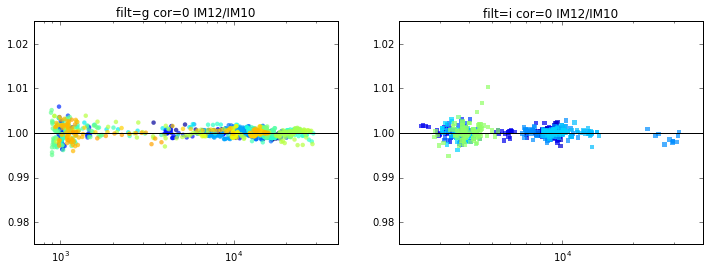

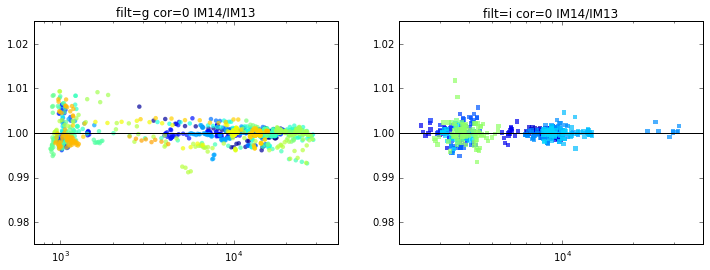

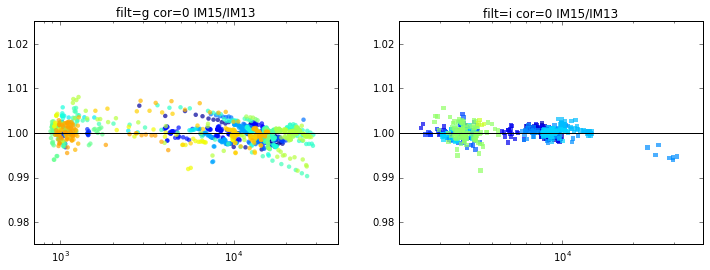

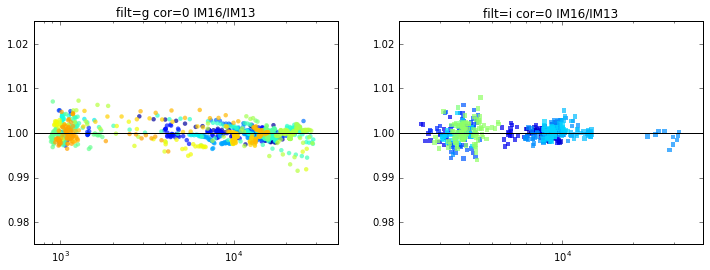

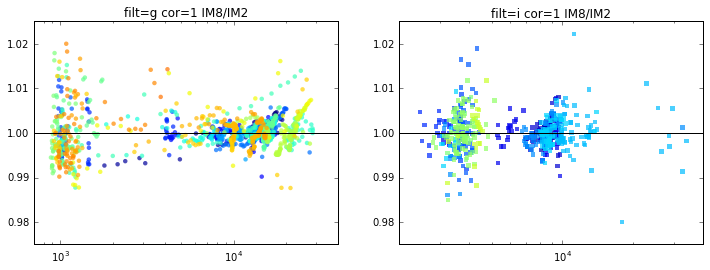

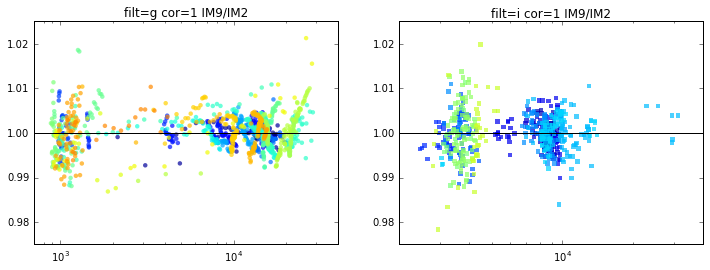

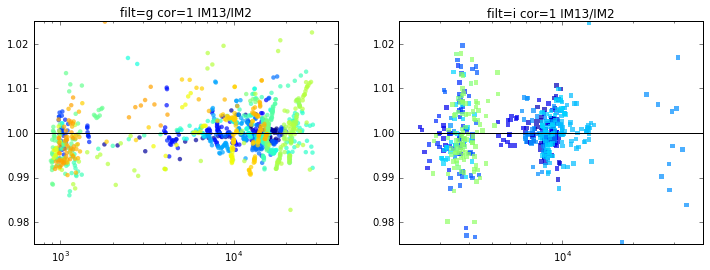

In [93]:
plotgains(norm=True,fromsky=True)

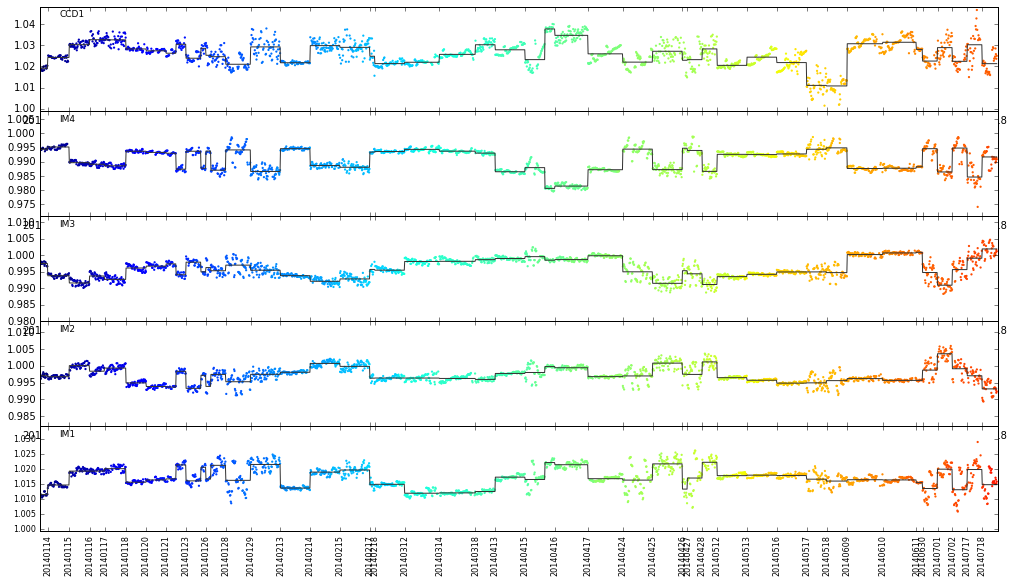

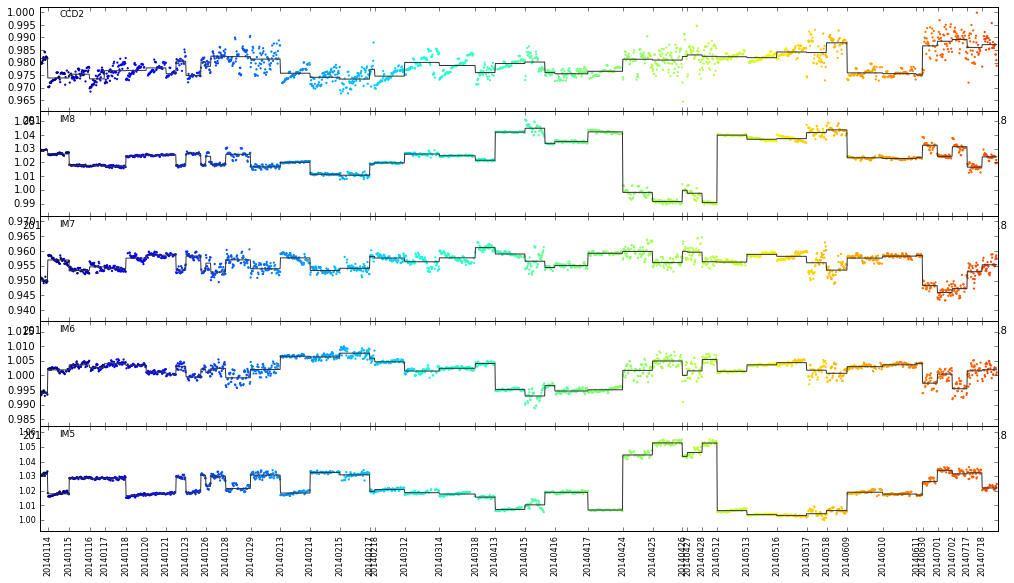

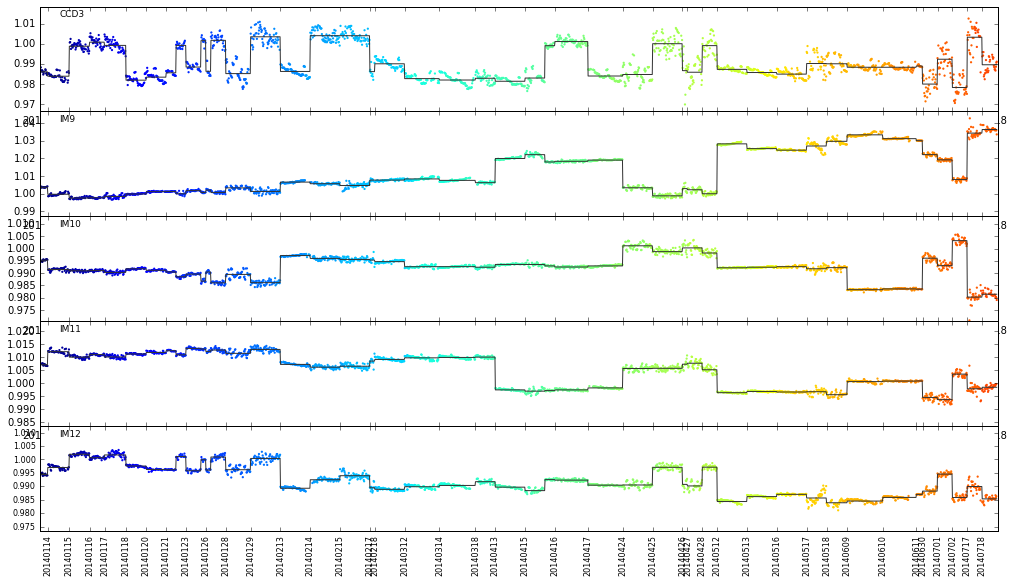

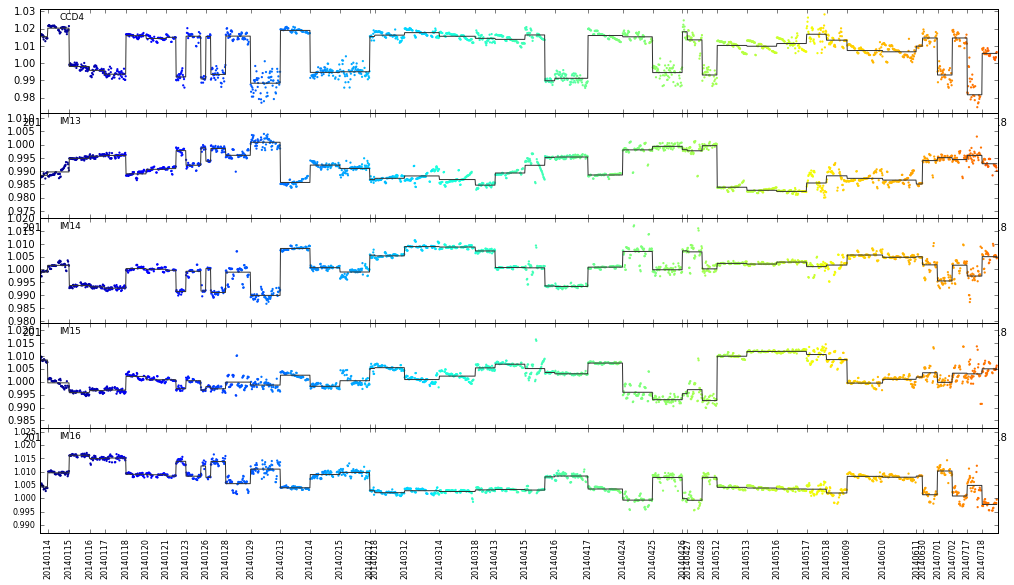

In [80]:
def gain_chart(gdat,savefn=None):
    gains = gdat['gains'].reshape(-1,2,4,4)
    for ccdi in range(4):
        figure(figsize=(14,8))
        subplots_adjust(0.04,0.08,0.99,0.99,0,0)
        ax = subplot(5,1,1)
        scatter(arange(nim),gains[:,1,ccdi,0],
               c=colorz,edgecolor='none',s=5)
        plot(arange(nim),gdat['gainCor'][:,1,ccdi*4],
            c='0.2',ls='-')
        ylim(0.99*scoreatpercentile(gains[:,1,ccdi,0].compressed(),1),
             1.01*scoreatpercentile(gains[:,1,ccdi,0].compressed(),99))
        text(0.02,0.97,'CCD%d'%(ccdi+1),size=9,va='top',transform=ax.transAxes)
        for ampj in range(4):
            k = 4*ccdi + ampj
            aax = subplot(5,1,ampj+2,sharex=ax)
            scatter(arange(nim),gains[:,0,ccdi,ampj],
                    c=colorz,edgecolor='none',s=5)
            plot(arange(nim),gdat['gainCor'][:,0,k],
                 c='0.2',ls='-')
            ylim(0.99*scoreatpercentile(gains[:,0,ccdi,ampj].compressed(),1),
                 1.01*scoreatpercentile(gains[:,0,ccdi,ampj].compressed(),99))
            text(0.02,0.97,'IM%d'%ampOrder[k],size=9,va='top',transform=aax.transAxes)
            if ampj==3:
                xticks(nightBreaks,gaindat['utDate'][nightBreaks],rotation='vertical')
        ax.set_xlim(-1,nim+1)
        tick_params(axis='both',which='major',labelsize=8)
        if savefn:
            savefig(savefn+'_CCD%d.pdf'%(ccdi+1))
gain_chart(gaindat,savefn="meangaincorr")

Instead of correcting to the *average* value within the CCD/FP, correct to a fixed reference.

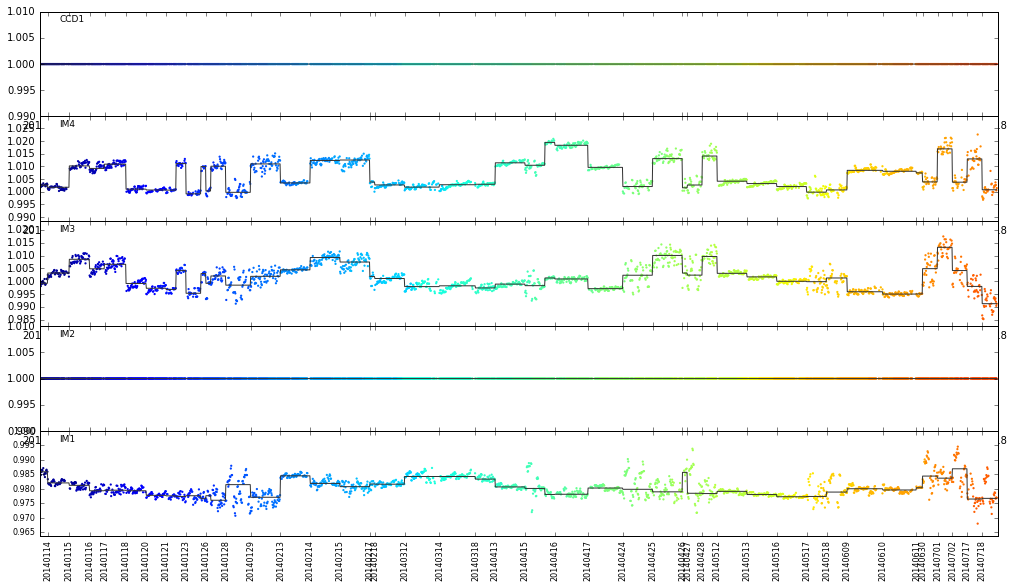

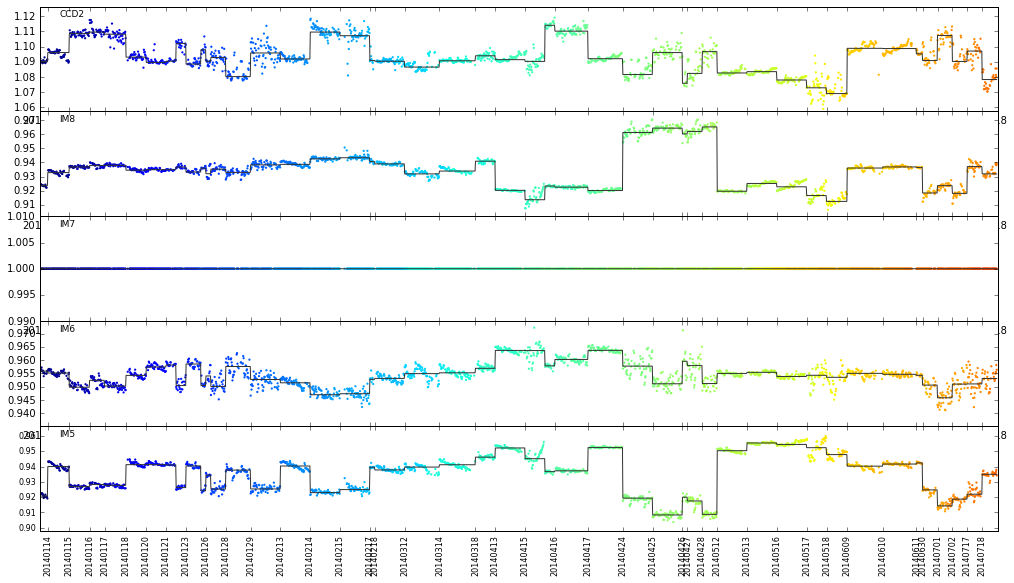

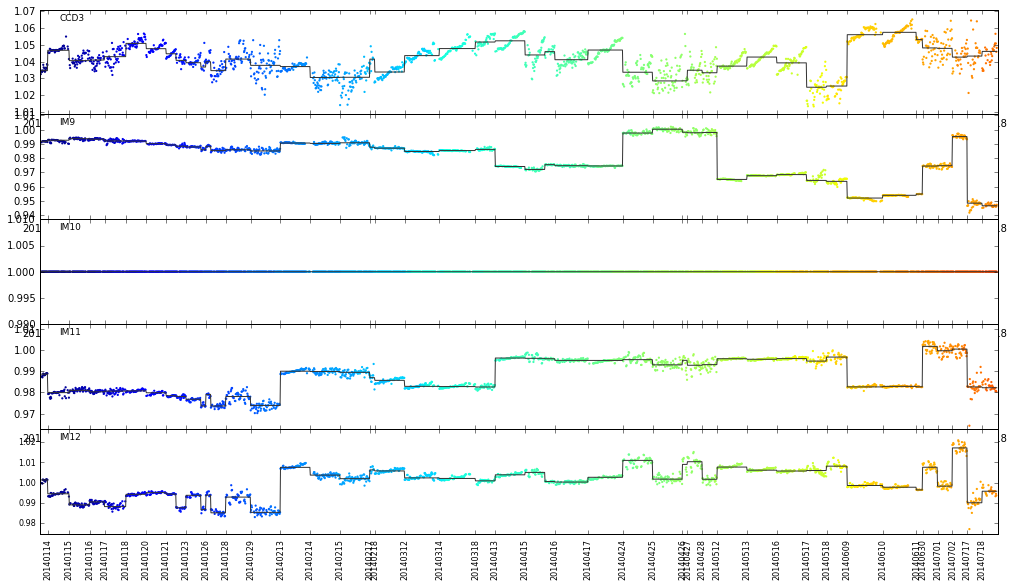

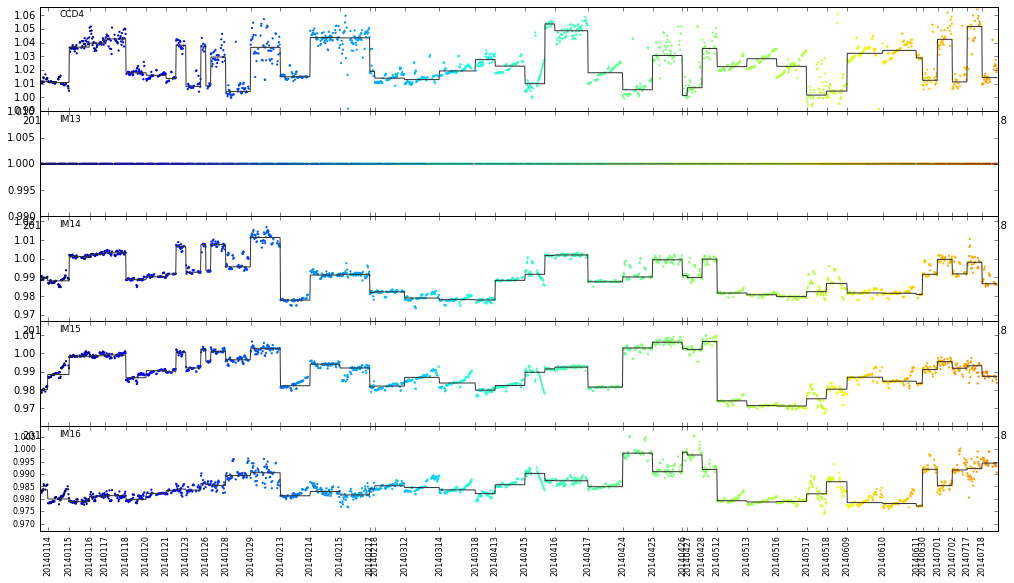

In [81]:
ampsky = gaindat['skys'].reshape(-1,4,4)
refsky = ampsky[:,[0,1,2,3],[2,1,1,0]][:,:,newaxis]
ampg = ampsky / refsky
ccdg = refsky / refsky[:,[0]]
ccdg = np.tile(ccdg,(1,1,4))
gaindat_fix = gaindat.copy()
gaindat_fix['gains'][:,0] = ampg.reshape(-1,16)
gaindat_fix['gains'][:,1] = ccdg.reshape(-1,16)
gaindat_fix = gaindat_fix.group_by(['utDate','filt'])
for g in gaindat_fix.groups:
    g['gainCor'][:,0,:] = ma.median(sigma_clip(g['gains'][:,0],axis=0,iters=2,sigma=2),axis=0)
    g['gainCor'][:,1,:] = ma.median(sigma_clip(g['gains'][:,1],axis=0,iters=2,sigma=2),axis=0)
gain_chart(gaindat_fix,savefn='refgaincorr')

In [101]:
reload(bokrmgnostic)
bokrmgnostic.all_gain_plots(gaindat_fix,pdfFile='bok_gain_fromref.pdf')

## Correlating the sky values across amplifiers

How well do the amplifiers correlate? Just using the raw sky numbers, calculate the correlation coefficents for all pairs of amplifiers. Showing 10^5(1-rho), so a larger number means worse correlation. Use this to determine which amplifiers to select as reference amplifiers, so that gain corrections are relative to the reference.

In [97]:
from scipy.stats import spearmanr
rho = zeros((16,16))
c = np.zeros_like(rho)
print '%4s' % '',
for j in range(16):
    print 'IM%02d' % ampOrder[j],
print
for i in range(16):
    print 'IM%02d' % ampOrder[i],
    for j in range(16):
        good = where(~(gaindat['skys'][:,i].mask | gaindat['skys'][:,j].mask))[0]
        rho[i,j] = spearmanr(gaindat['skys'][good,i],gaindat['skys'][good,j])[0]
        c[i,j] = 1e5*(1-rho[i,j])
        print '%4d' % c[i,j],
    print
print

     IM04 IM03 IM02 IM01 IM08 IM07 IM06 IM05 IM09 IM10 IM11 IM12 IM13 IM14 IM15 IM16
IM04    0    9    5    7   33    5    7    9   45   16   13   13   12   25   21   13
IM03    9    0    4    4   30   13   22   22   39   23   25   21   20   49   46   26
IM02    5    4    0    1   32   10   15   12   37   13   17   12   20   54   48   25
IM01    7    4    1    0   33   11   18   17   34   14   19   12   24   45   35   29
IM08   33   30   32   33    0   21   30   50   42   44   58   50   34   47   26   37
IM07    5   13   10   11   21    0    5   12   39   19   23   21   10   20   13   13
IM06    7   22   15   18   30    5    0    9   38   16   17   20   17   23   18   16
IM05    9   22   12   17   50   12    9    0   53   14   14   15   22   36   33   23
IM09   45   39   37   34   42   39   38   53    0   34   48   42   66   73   59   66
IM10   16   23   13   14   44   19   16   14   34    0    9    6   29   45   34   33
IM11   13   25   17   19   58   23   17   14   48    9    0    4 

In [98]:
cc = hstack([rho[i:i+4,i:i+4].prod(axis=1) for i in range(0,16,4)]).reshape(4,4)
cc = 1e5*(1-cc)
print cc
print cc.argmin(axis=1)
jj = arange(0,16,4) + cc.argmin(axis=1)
print ' '.join(['IM%02d' % ampOrder[j] for j in jj])
best_ccd1 = jj[0]
jj = arange(0,16,4) + c[best_ccd1].reshape(4,4).argmin(axis=1)
print c[best_ccd1].reshape(4,4)
print c[best_ccd1][jj]
print ' '.join(['IM%02d' % ampOrder[j] for j in jj])

[[  21.82909024   17.80793088   11.27166255   13.66422539]
 [ 102.50018023   39.79958466   44.88356628   72.68036942]
 [ 126.14912565   51.01171466   62.86335949   53.39784267]
 [  19.45074983   26.5721519    20.88904979   19.37077168]]
[2 1 1 3]
IM02 IM07 IM10 IM16
[[  5.31019152   4.21076944   0.           1.75109191]
 [ 32.8563004   10.65332554  15.33245472  12.75211593]
 [ 37.23717439  13.64139773  17.7516972   12.42043149]
 [ 20.86249217  54.85351204  48.02824422  25.87103481]]
[  0.          10.65332554  12.42043149  20.86249217]
IM02 IM07 IM12 IM13


The above is a guess at which amps correlate best. First sum the correlation coefficients that cross each amplifier within each CCD, and find the one that correlates best with the others. Using the best amp from CCD1, compare how it correlates to the amps on other CCDs.

Although this selects IM16 as the best amp on CCD4, select IM13 since it is near the center and the difference between the two is not significant (19.37 vs. 19.45). Likewise, prefer IM10 on CCD3 to IM12 (13.6 vs. 12.4).

From the strip charts it would appear that IM7 tracks IM2 most closely, while IM10 and IM13 show large deviations. That's not really reflected in the correlation coefficients...

The final set of reference amps is **IM2**, **IM7**, **IM10**, and **IM13**.
These are indexed by [2,1,1,0] on each CCD, and [2,5,9,12] when ordered by HDU.

In [95]:
jj = [2,5,9,12]
print ' '.join(['IM%02d' % ampOrder[j] for j in jj])

IM02 IM07 IM10 IM13
